In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.resnet50 import ResNet50
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

base_model = ResNet50(weights='imagenet', include_top=False)

94658560/94653016 [==============================] - 157s 2us/step


In [3]:
from keras.layers.pooling import GlobalAveragePooling2D
nb_classes = 17
def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    FC_SIZE =1024
    x = base_model.output
    print(x.shape)
    x = GlobalAveragePooling2D()(x)
    print(x.shape)
    x = Dense(FC_SIZE, activation='relu')(x) 
    print(x.shape)
    predictions = Dense(nb_classes, activation='softmax')(x) 
    model = Model(input=base_model.input, output=predictions)
    return model

In [4]:
model = add_new_last_layer(base_model,nb_classes)

(?, ?, ?, 2048)
(?, 2048)
(?, 1024)


c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [5]:
def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
import os
import glob
from shutil import copyfile
class_names = ["daffodil", "snowdrop", "lily_valley", "bluebell", "crocus",
              "iris", "tigerlily", "tulip", "fritillary", "sunflower", 
              "daisy", "colts_foot", "dandelion", "cowslip", "buttercup",
              "windflower", "pansy"]


In [8]:
class_limit = 17
label = 0
#X_train_orig = np.array([]).reshape((0,224,224,3))
#Y_train_orig = np.array([]).reshape((1,0))
X_train_orig = np.array([]).reshape((0,224,224,3))
#Y_train_orig = np.array([]).reshape((1,0))
Y_train_orig = []
#print(X_train_orig.shape)
train_path = "F:\\Flower-CNN-master\\Flower-CNN-master\\17_flowers\\train"
for x in range(class_limit):
    curr_path = train_path + "\\" + class_names[label]
    os.chdir(curr_path)
    for image_path in glob.glob(curr_path + "\\*.jpg"):
        img = image.load_img(image_path,target_size = (224,224,3))
        x = image.img_to_array(img)
        x = np.expand_dims(x,axis = 0)
        x = preprocess_input(x)
        X_train_orig = np.vstack((X_train_orig,x))
        #print(X_train_orig.shape)
        Y_train_orig.append(label)
    print("Folder with label "+str(class_names[label])+" is complete")
    label+=1

Y_train_orig = np.reshape(Y_train_orig,[1,len(Y_train_orig)])

Folder with label daffodil is complete
Folder with label snowdrop is complete
Folder with label lily_valley is complete
Folder with label bluebell is complete
Folder with label crocus is complete
Folder with label iris is complete
Folder with label tigerlily is complete
Folder with label tulip is complete
Folder with label fritillary is complete
Folder with label sunflower is complete
Folder with label daisy is complete
Folder with label colts_foot is complete
Folder with label dandelion is complete
Folder with label cowslip is complete
Folder with label buttercup is complete
Folder with label windflower is complete
Folder with label pansy is complete


In [9]:
class_limit = 17
label = 0
X_test_orig = np.array([]).reshape((0,224,224,3))
Y_test_orig = []

test_path = "F:\\Flower-CNN-master\\Flower-CNN-master\\17_flowers\\validation"
for x in range(class_limit):
    curr_path = test_path + "\\" + class_names[label]
    os.chdir(curr_path)
    for image_path in glob.glob(curr_path + "\\*.jpg"):
        img = image.load_img(image_path,target_size = (224,224,3))
        x = image.img_to_array(img)
        x = np.expand_dims(x,axis = 0)
        x = preprocess_input(x)
        X_test_orig = np.vstack((X_test_orig,x))
        #print(X_train_orig.shape)
        Y_test_orig.append(label)
    print("Folder with label "+str(class_names[label])+" is complete")
    label+=1

Y_test_orig = np.reshape(Y_test_orig,[1,len(Y_test_orig)])

Folder with label daffodil is complete
Folder with label snowdrop is complete
Folder with label lily_valley is complete
Folder with label bluebell is complete
Folder with label crocus is complete
Folder with label iris is complete
Folder with label tigerlily is complete
Folder with label tulip is complete
Folder with label fritillary is complete
Folder with label sunflower is complete
Folder with label daisy is complete
Folder with label colts_foot is complete
Folder with label dandelion is complete
Folder with label cowslip is complete
Folder with label buttercup is complete
Folder with label windflower is complete
Folder with label pansy is complete


In [10]:
def convert_to_one_hot(A,C):
    A = np.eye(C)[A.reshape(-1)].T
    return A

In [11]:
print(X_train_orig.shape)
print(Y_train_orig.shape)

X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 17).T
Y_test = convert_to_one_hot(Y_test_orig, 17).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

(1190, 224, 224, 3)
(1, 1190)
number of training examples = 1190
number of test examples = 170
X_train shape: (1190, 224, 224, 3)
Y_train shape: (1190, 17)
X_test shape: (170, 224, 224, 3)
Y_test shape: (170, 17)


In [12]:

setup_to_transfer_learn(model,base_model)

In [13]:
model.fit(X_train,Y_train,epochs=2,batch_size=34)

Epoch 1/2
1190/1190 [==============================] - 2306s 2s/step - loss: 0.9477 - acc: 0.7353
Epoch 2/2
1190/1190 [==============================] - 2123s 2s/step - loss: 0.1129 - acc: 0.9664


In [14]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

170/170 [==============================] - 293s 2s/step
Loss = 0.9900390035965864
Test Accuracy = 0.7294117648811901


Input image shape: (1, 224, 224, 3)


c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


daisy


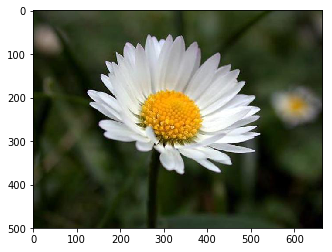

In [22]:
img_path = 'images/daisy.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
#print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(class_names[np.argmax(model.predict(x))])

Input image shape: (1, 224, 224, 3)


c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


sunflower


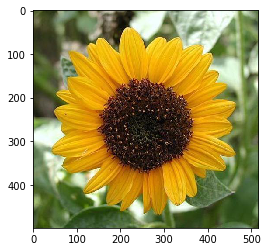

In [23]:
img_path = 'images/sunflower.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
#print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(class_names[np.argmax(model.predict(x))])

Input image shape: (1, 224, 224, 3)


c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


tulip


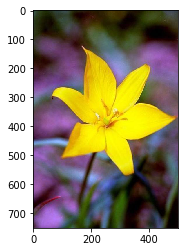

In [26]:
img_path = 'images/tulip.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
#print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(class_names[np.argmax(model.predict(x))])